# Transforming Data

### Tidy Data

Analysis-ready data, or 'tidy data', is a central concept in data science.  The term was coined by Hadley Wickham[^1] to describe best practices long known in the relational database community, specifically, conventions around formatting tabular data known as [Cobb's Third Normal Form](https://en.wikipedia.org/wiki/Third_normal_form). In this form, each row represents an observation and each column represents a variable. These conventions allow us to leverage powerful software and techniques for data analysis and visualization more easily, as many such tools are designed with tidy data structures in mind.  However, wild-caught data often does not follow these rules. Consider this example of NASA data on land ice mass:


[^1]: Wickham (2014). Tidy data.  Journal of Statistical Software 14(10) DOI:10.18637/jss.v059.i10 https://vita.had.co.nz/papers/tidy-data.pdf

In [1]:
import pandas as pd

df = pd.read_csv("http://climate.nasa.gov/system/internal_resources/details/original/499_GRN_ANT_mass_changes.csv",
                skiprows=10, names=['date', 'greenland', 'antarctica'])
df

,date,greenland,antarctica
0,2002.29,1490.68,967.20
1,2002.35,1485.69,978.55
2,2002.62,1286.84,512.02
3,2002.71,1257.85,858.85
4,2002.79,1257.17,693.87
...,...,...,...
135,2014.45,-1672.08,-1021.70
136,2014.62,-1985.59,-1067.84
137,2014.71,-2024.82,-780.87
138,2014.79,-1973.96,-904.38


The column heading we have called 'greenland' is not a single variable (feature) being observed, but in fact a mashup of two different variables -- the ice mass (in gigatons) on the location of Greenland. (In the original data file it has the name `Greenland mass (Gt)`, which more clearly indicates this mash-up but does not follow our naming conventions.  Likewise the column called 'antarctica' again measures land ice mass, but at a different location.  A "tidy" version of this data would use one column to indicate location (Greenland or Antarctica) and another column to indicate ice mass at that location.  

To fix this, we need to *pivot* the data table into a "long" form, with a single column for ice mass and a single column for location.  While there are many ways to do this, we will rely on the `ibis` framework which provides one of the most consistent and powerful interfaces for tabular data operations.  We begin by loading the ibis library and establishing a "connection" to a backend engine.

In [2]:
import ibis
from ibis import selectors as s
con = ibis.duckdb.connect()

We add our pandas table to the ibis connection using the method `create_table`.  This allows us to manipulate the table using ibis methods rather than pandas.  We will later see other ways to create `ibis` tables directly from a wide range of data other than pandas data.frames.

We then use the `pivot_longer()` method to transform our data.  We use the `ibis.selectors` methods to indicate which columns we are aggregating in the pivot.  Optionally, we indicate the name of the new column that will contain the previous column names (greenland, antarctica) and the name of the column that will contain the cell values (the ice mass).

In [3]:
land_ice = (con
 .create_table("land_ice", df, overwrite=True)
 .pivot_longer(s.any_of('greenland', 'antarctica'),
               names_to= "location", values_to = "ice_mass")
)

land_ice.execute()

,date,location,ice_mass
0,2002.29,greenland,1490.68
1,2002.29,antarctica,967.20
2,2002.35,greenland,1485.69
3,2002.35,antarctica,978.55
4,2002.62,greenland,1286.84
...,...,...,...
275,2014.71,antarctica,-780.87
276,2014.79,greenland,-1973.96
277,2014.79,antarctica,-904.38
278,2014.88,greenland,-1911.78


Note the use of `.execute()` at the end of the ibis command to see the results.  `ibis` uses a sophisticated strategy called "lazy evaluation", in which it does not actually run the code we provide until absolutely necessary.  While this feels cumbersome now, these small extra steps will pay big dividends for us when we move to big data sources that historically courses have needed to teach entirely different tools for.


Now that are data is 'tidy', some operations are much easier. For instance, plotting two lines, with a legend, merely requires the single aesthetic mapping of color to the location column: `color = "location"`

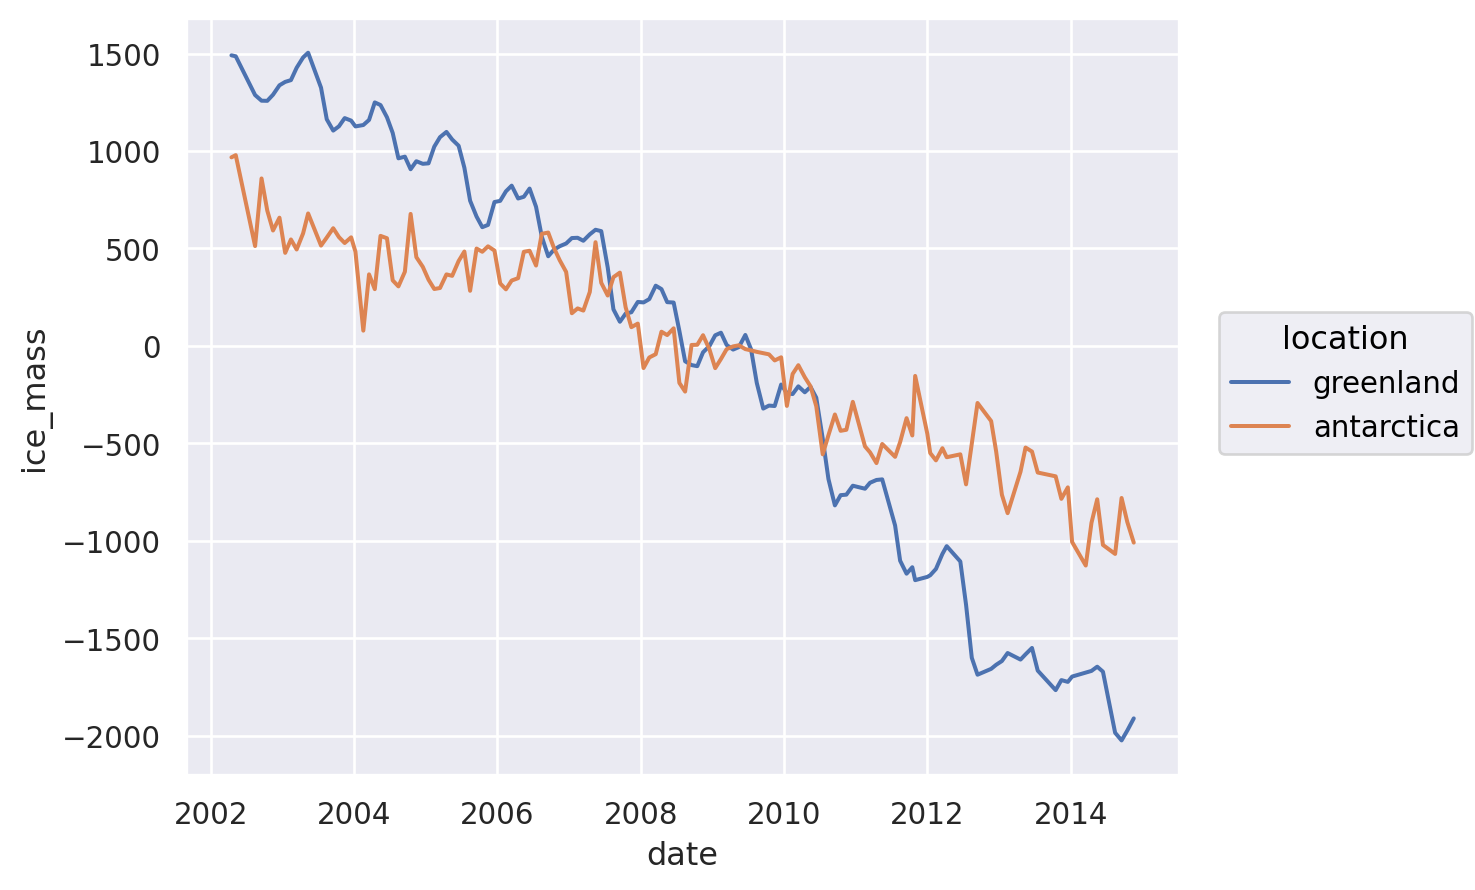

In [4]:
import seaborn.objects as so
p = (so.Plot(land_ice, 
             x = "date", 
             y = "ice_mass", 
             color = "location")
     .add(so.Line())
    )

p

We can map this additional column to different aesthetics just as easily.  This illustrates the value of well-structured data and abstract grammar for operating on it.  For instance, having subplots (facets) based on this data:

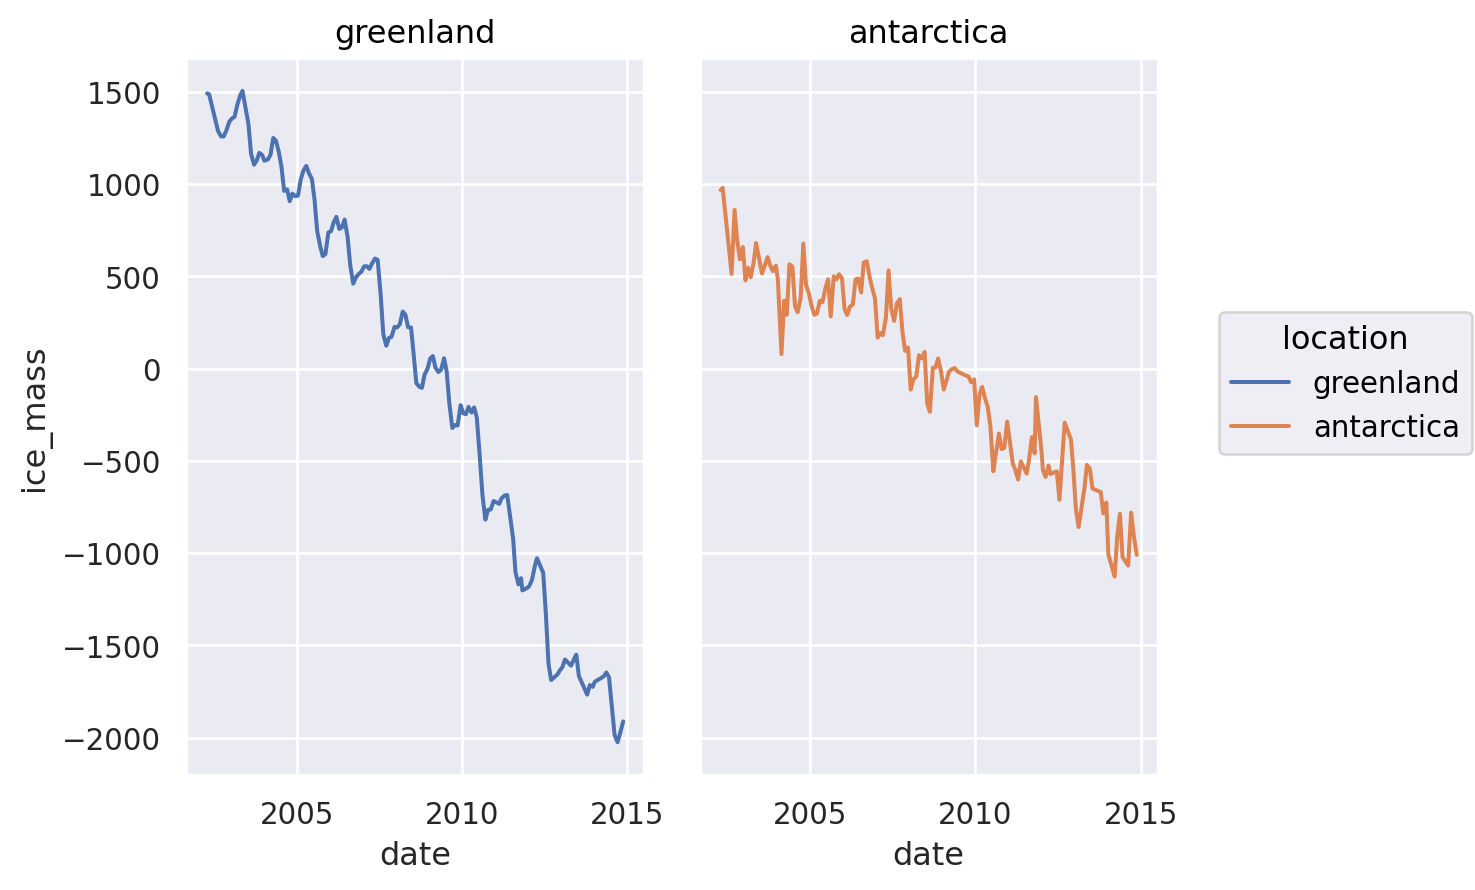

In [5]:
p.facet("location")